In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ndarray
from pandas import DataFrame, read_csv, Series
from matplotlib.pyplot import savefig, show, figure
from helpers.dslabs_functions import (IQR_FACTOR, NR_STDEV, count_outliers, get_variable_types, plot_multibar_chart, 
                                    determine_outlier_thresholds_for_var)

In [6]:
df = pd.read_csv('../../datasets/class_pos_covid.csv')

c:\Users\Ana\Desktop\github-projects\Data-Science-project\labs\preparation\helpers\dslabs_functions.py:197: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = to_datetime(df[c], errors='raise')
c:\Users\Ana\Desktop\github-projects\Data-Science-project\labs\preparation\helpers\dslabs_functions.py:197: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = to_datetime(df[c], errors='raise')
c:\Users\Ana\Desktop\github-projects\Data-Science-project\labs\preparation\helpers\dslabs_functions.py:197: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = to_datetime(df[c], error

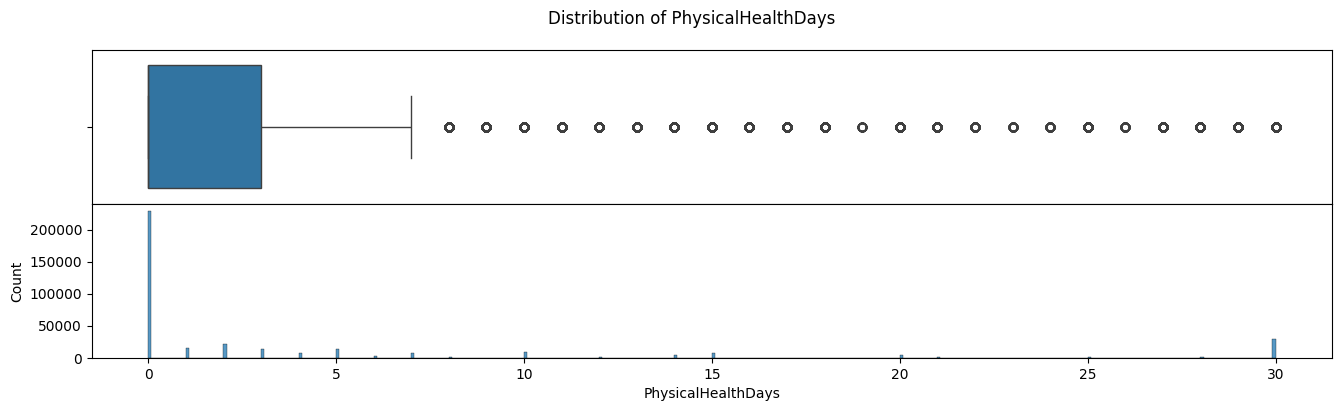

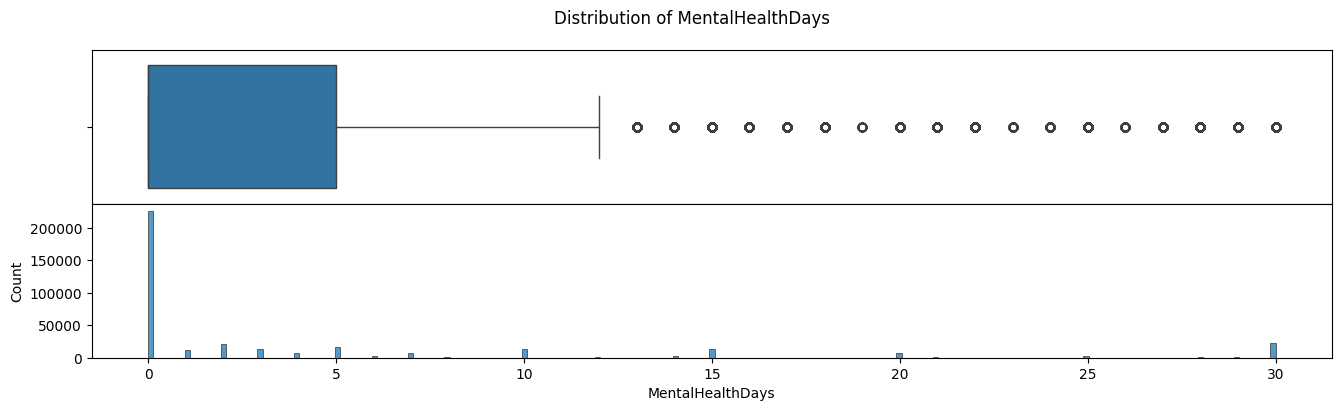

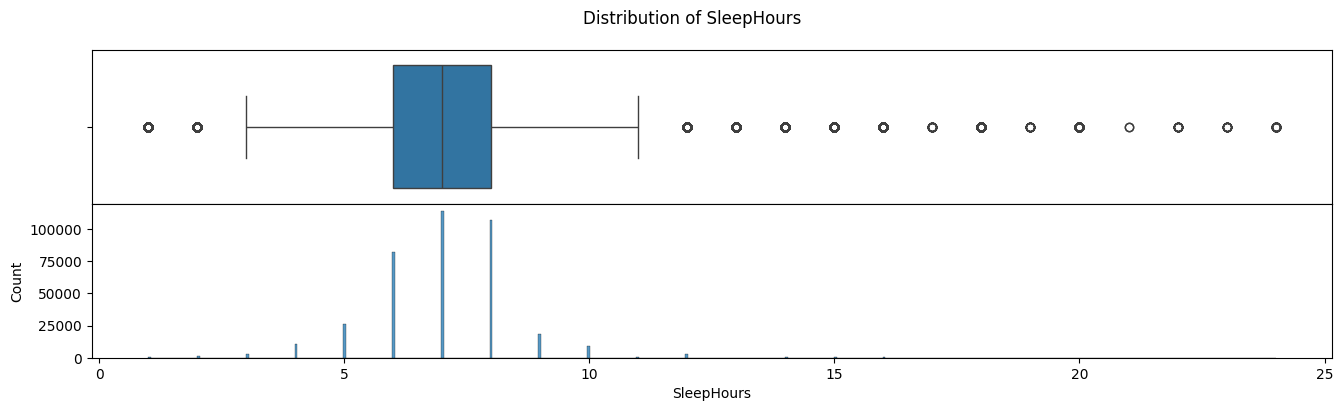

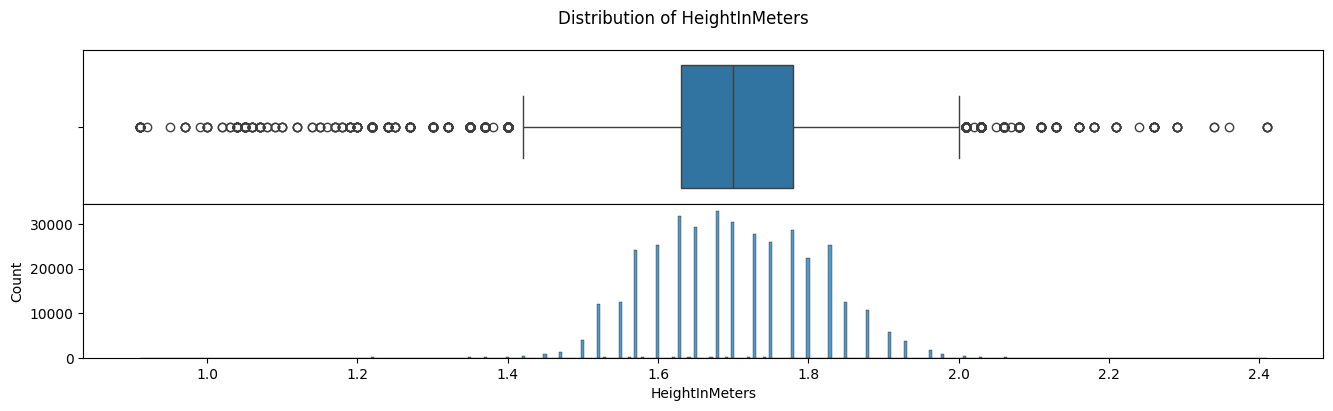

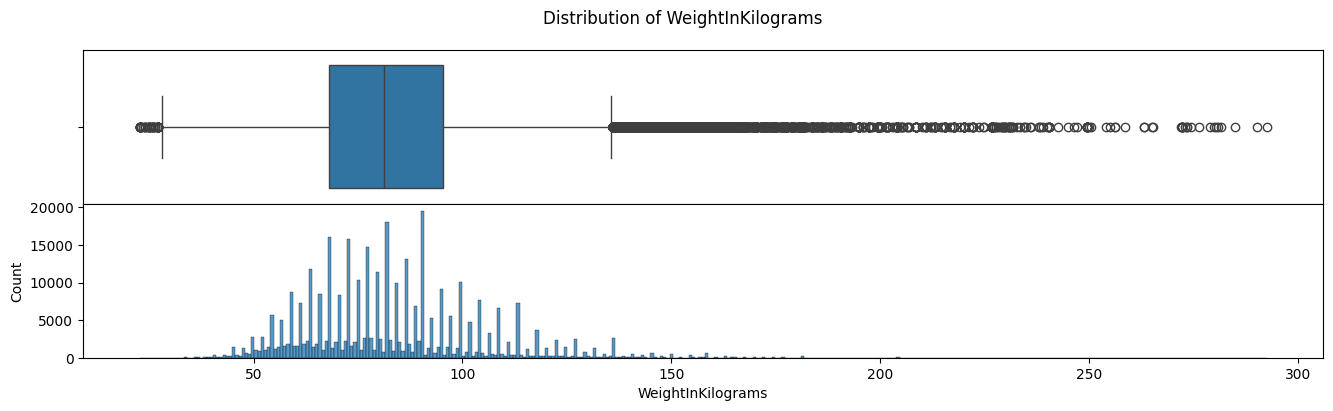

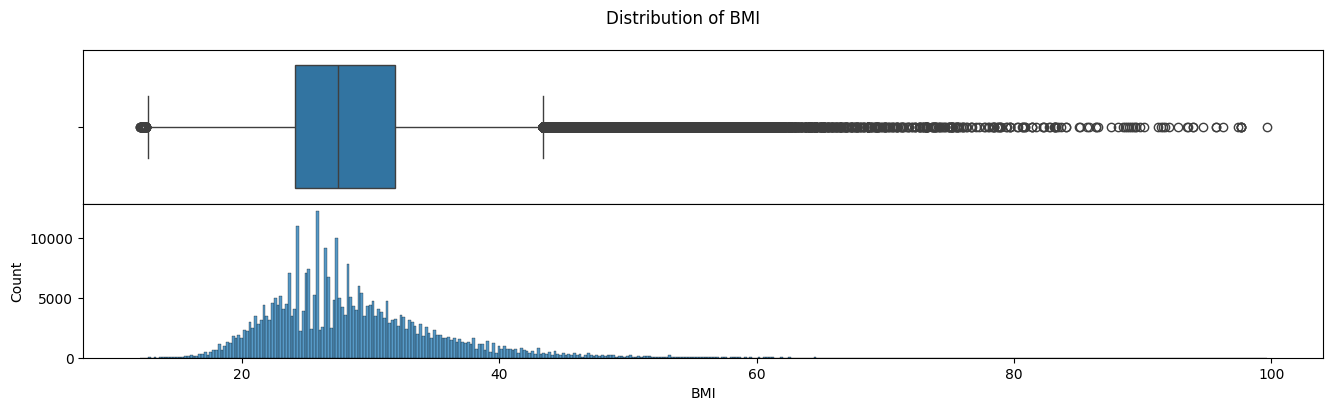

In [7]:
variables_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variables_types["numeric"]

for col in numeric:
  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 4))
  plt.suptitle(f"Distribution of {col}")
  sns.boxplot(data=df, x=col, ax=ax1)
  ax1.set_xlabel(None)
  ax1.get_xaxis().set_ticks([])
  sns.histplot(data=df, x=col, ax=ax2)
  plt.subplots_adjust(hspace=0)
  print("\n")
  plt.show()

In [8]:
df[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,371944.0,4.384991,8.742091,0.00,0.00,0.00,3.00,30.00
MentalHealthDays,373512.0,4.415732,8.404087,0.00,0.00,0.00,5.00,30.00
SleepHours,376556.0,7.022823,1.491101,1.00,6.00,7.00,8.00,24.00
HeightInMeters,372301.0,1.702571,0.107171,0.91,1.63,1.70,1.78,2.41
WeightInKilograms,360571.0,83.217059,21.485738,22.68,68.04,81.19,95.25,292.57
BMI,355324.0,28.586092,6.571412,12.02,24.14,27.44,31.84,99.64


We will use definition of outlier, based on the interquartile range: An outlier is any value:
-	less than Q1 - 1.5x IQR
-	or higher than Q3 + 1.5x IQR.

for the HeightInMeters, WeightInKilograms, BMI: we will remove the outliners, as these are people who stand out from the population average.  <br>
for SleepHours we will replace the outliners with the median, as these may be the wrong responses to the survey.  <br>
the other two variables we leave as they are, as the question is about healthy days of the month, the variable has values 0 - 30, which we do not consider outliners

In [9]:
outliers: dict[str, int] = count_outliers(df, numeric, nrstdev=2, iqrfactor=1.5)
outliers

{'iqr': [62342, 52202, 5999, 1350, 8753, 10899],
 'stdev': [32260, 27726, 19998, 9954, 15353, 15225]}

In [10]:
for col in numeric:
  Q1, Q3 = df[col].quantile([0.25,0.75])
  IQR = Q3 - Q1
  right = Q3 + 1.5 * IQR
  left = Q1 - 1.5 * IQR
  n = len(df.loc[(df[col] < left) | (df[col] > right)])
  print(f"{col}:\n\tOutlier Num = {n}\n\tOutlier Percentage = {n*100/len(df):.2f}%\n")

PhysicalHealthDays:
	Outlier Num = 62342
	Outlier Percentage = 16.37%

MentalHealthDays:
	Outlier Num = 52202
	Outlier Percentage = 13.70%

SleepHours:
	Outlier Num = 5999
	Outlier Percentage = 1.57%

HeightInMeters:
	Outlier Num = 1350
	Outlier Percentage = 0.35%

WeightInKilograms:
	Outlier Num = 8753
	Outlier Percentage = 2.30%

BMI:
	Outlier Num = 10899
	Outlier Percentage = 2.86%



## Dropping outliers

In [11]:
vars_drop_outliers = [
 'HeightInMeters',
 'WeightInKilograms',
 'BMI']

In [12]:
def drop_outliers(df, cols, path_end_file, std: bool = True, thres: int=NR_STDEV):
    print(f"Original data: {df.shape}")
    if cols is not None:
        data: DataFrame = df.copy(deep=True)
        summary5: DataFrame = data[cols].describe()
        for var in cols:
            top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
                summary5[var], std_based = std, threshold = thres
            )
        
            outliers: Series = data[(data[var] > top_threshold) | (data[var] < bottom_threshold)]
            print(outliers.shape)
            n = len(data.loc[(data[var] > top_threshold) | (data[var] < bottom_threshold)])
            print(n)
            data.drop(outliers.index, axis=0, inplace=True)

        data.to_csv(f"drop_{path_end_file}", index=True)
        return(print(f"Data after dropping outliers: {data.shape}"))
    
    else:
        return(print("There are no numeric variables"))

In [13]:
drop_outliers(df, vars_drop_outliers, 'outliers.csv', std = False, thres = IQR_FACTOR)

Original data: (380932, 40)


(1350, 40)
1350
(8628, 40)
8628
(5217, 40)
5217
Data after dropping outliers: (365737, 40)


In [14]:
df2 = pd.read_csv('drop_outliers.csv')
df2[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,357136.0,4.243417,8.604330,0.00,0.00,0.00,3.00,30.00
MentalHealthDays,358603.0,4.299560,8.291284,0.00,0.00,0.00,4.00,30.00
SleepHours,361596.0,7.031040,1.477653,1.00,6.00,7.00,8.00,24.00
HeightInMeters,357162.0,1.701848,0.103742,1.42,1.63,1.70,1.78,2.00
WeightInKilograms,345428.0,80.970332,18.115346,28.00,68.04,79.38,91.63,135.62
BMI,340329.0,27.828741,5.311187,12.69,24.02,27.27,31.17,43.38


## Replacing outliers with fixed value

In [15]:
vars_replace_outliers = ['SleepHours']

In [16]:
def replace_outliers(df, cols, path_end_file, std: bool = True, thres: int=NR_STDEV):
    print(f"Original data: {df.shape}")
    if cols is not None:
        data: DataFrame = df.copy(deep=True)
        summary5: DataFrame = data[cols].describe()
        for var in cols:
            top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
                summary5[var], std_based = std, threshold = thres
            )

            n = len(data.loc[(data[var] > top_threshold) | (data[var] < bottom_threshold)])
            print(n)

            median: float = data[var].median()
            data[var] = data[var].apply(lambda x: median if x > top_threshold or x < bottom_threshold else x)

        data.to_csv(f"replace_{path_end_file}", index=True)
        return(print(f"Data after dropping outliers: {data.shape}"))
    
    else:
        return(print("There are no numeric variables"))

In [17]:
replace_outliers(pd.read_csv('drop_outliers.csv'), vars_replace_outliers, 'drop_outliers.csv', std = False, thres = IQR_FACTOR)

Original data: (365737, 41)
5608
Data after dropping outliers: (365737, 41)


In [18]:
df3 = pd.read_csv('replace_drop_outliers.csv')
df3[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,357136.0,4.243417,8.604330,0.00,0.00,0.00,3.00,30.00
MentalHealthDays,358603.0,4.299560,8.291284,0.00,0.00,0.00,4.00,30.00
SleepHours,361596.0,7.000075,1.252315,3.00,6.00,7.00,8.00,11.00
HeightInMeters,357162.0,1.701848,0.103742,1.42,1.63,1.70,1.78,2.00
WeightInKilograms,345428.0,80.970332,18.115346,28.00,68.04,79.38,91.63,135.62
BMI,340329.0,27.828741,5.311187,12.69,24.02,27.27,31.17,43.38


In [19]:
import numpy as np
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from sklearn.model_selection import train_test_split

# Nastavimo seme
np.random.seed(0)
# Razdelimo podatke
train, test = train_test_split(df, test_size=0.2)

In [82]:
target = "CovidPos"
file_tag = "CovidPos"

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
show()

ValueError: could not convert string to float: 'Indiana'

<Figure size 600x450 with 0 Axes>

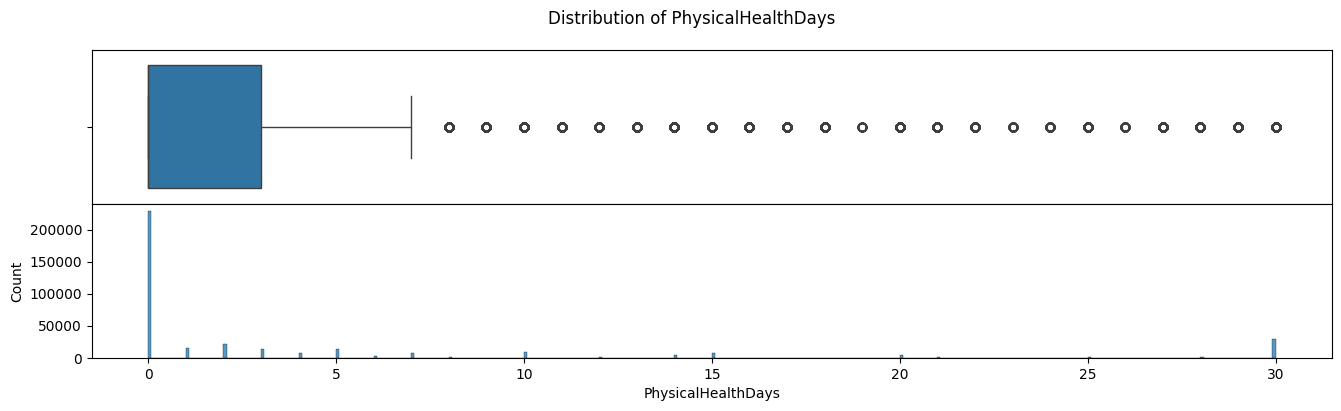

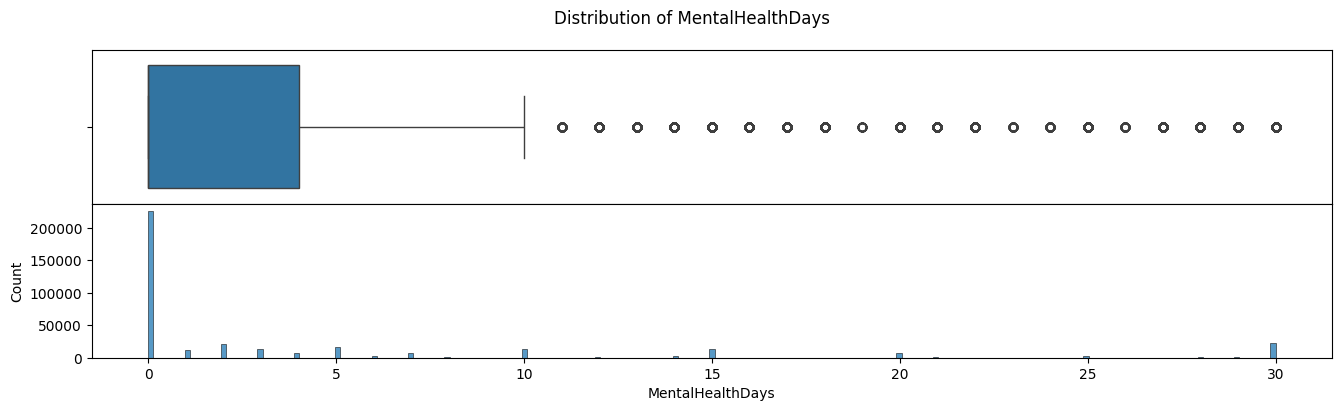

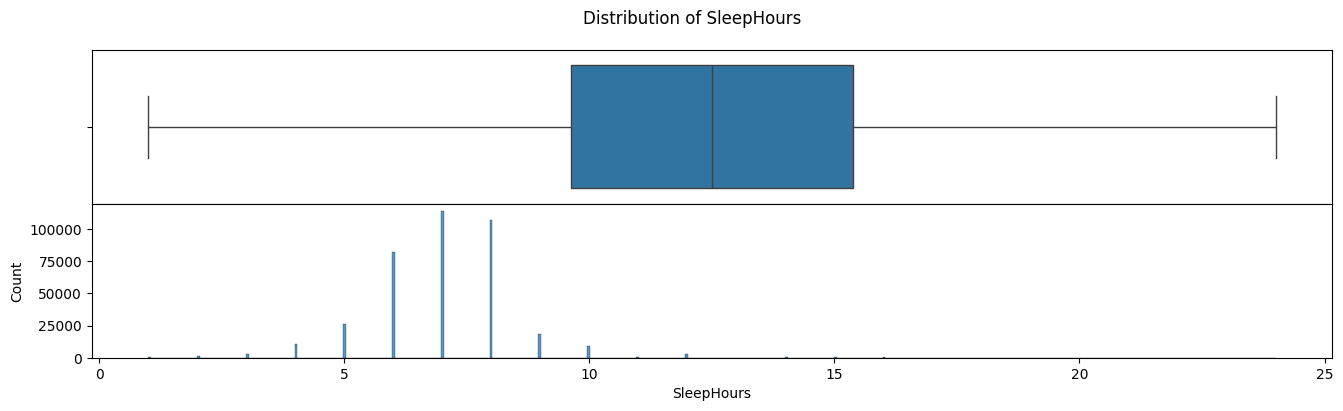

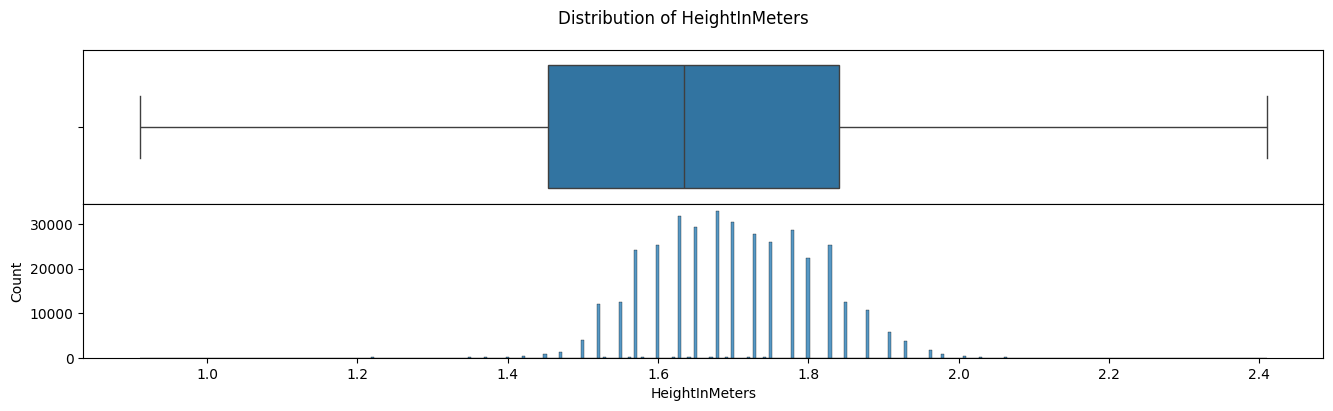

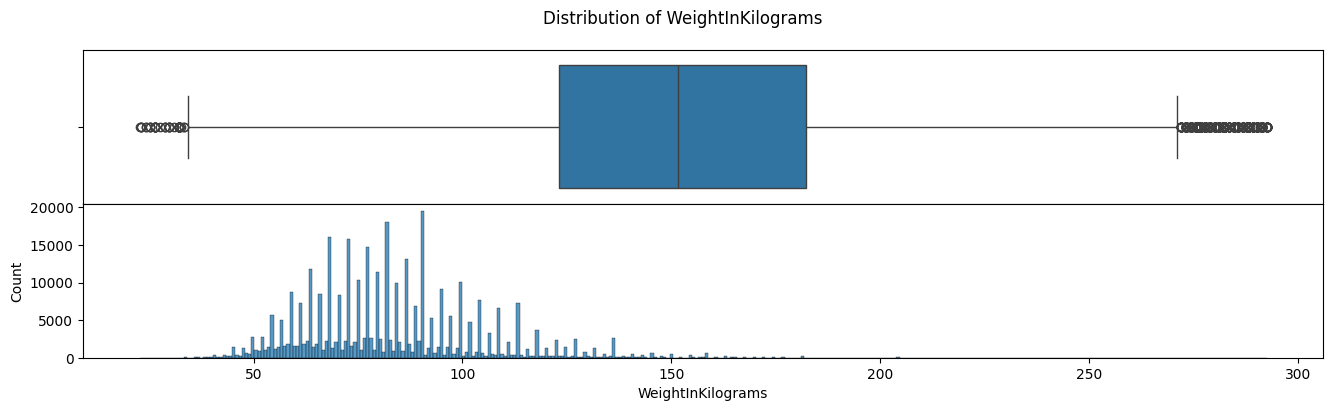

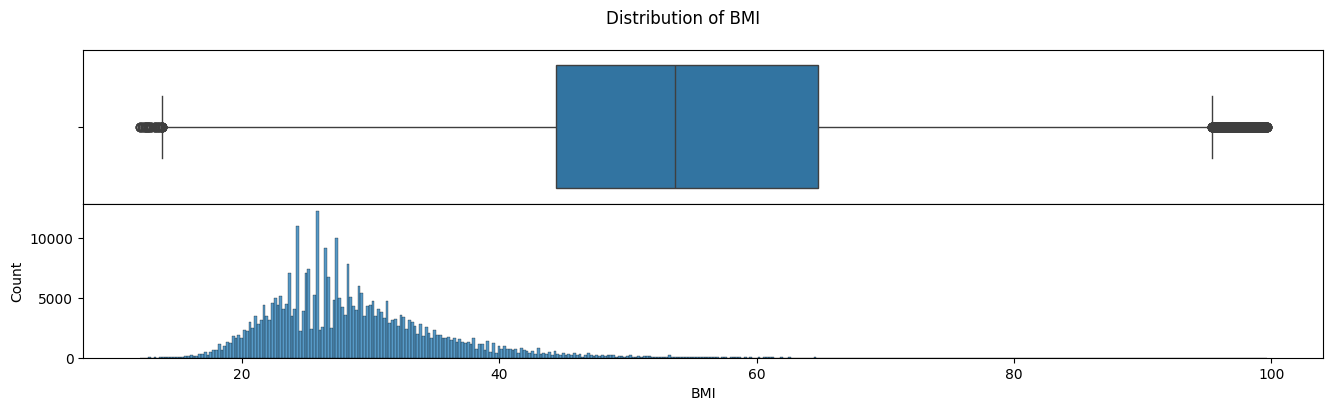

In [20]:
for col in numeric:
  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 4))
  plt.suptitle(f"Distribution of {col}")
  sns.boxplot(data=df3, x=col, ax=ax1)
  ax1.set_xlabel(None)
  ax1.get_xaxis().set_ticks([])
  sns.histplot(data=df, x=col, ax=ax2)
  plt.subplots_adjust(hspace=0)
  print("\n")
  plt.show()